# Objective

Out of the baseline models that were tested, the moving average model performed best with the following stats:

| Metric        | Value
| ------------- |------------- 
| RMSE          | 1.613
| Mean Error    | -0.26
| Median Error  |  0.0
| 95% Error     |  3.0
| 99% Error     |  4.0
| Max Error     |  6.0

The purpose of this notebook is to improve on the moving average model and incorporate the trend and seasonality that was apparent in the time series decomposition and moving average model errors. Ideally, we would like to:

* Provide conservative instead of overly optimistic estimates (non-negative RMSE)
* Reduce the 99% bound

In this notebook, we'll evaluate two different univariate time series models that incorporate trend and seasonality:

1. Holt-Winters (exponential smoothing)
2. Seasonal ARIMA

# Libraries

In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
import warnings
warnings.simplefilter('ignore')
sys.path.insert(1, os.path.join(sys.path[0], '../src'))

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import itertools

from app.feature_data import load_feature_data
from app.model.diagnostics import display_results
from app.model.seasonal_models import evalute_model

from statsmodels.tsa.holtwinters import ExponentialSmoothing

%matplotlib inline

# Data

In [3]:
X = load_feature_data('../data/processed/weekly-rain-day-counts.csv')
X.head()

,rainEvents
date,
2009-12-28,3
2010-01-04,4
2010-01-11,1
2010-01-18,2
2010-01-25,6


In [4]:
y = X.sort_index()['rainEvents']
y.head()

date
2009-12-28    3
2010-01-04    4
2010-01-11    1
2010-01-18    2
2010-01-25    6
Name: rainEvents, dtype: int64

# Seasonal Decomposition

# Models

Create a function to train and evaluate seasonal models. This iteration of the training and evaluation procedure will use a straightforward walk-forward one-step ahead forecast but we could also consider using nested cross valiation on the tail end of the training set for each fold.

## Holt Winters

In [5]:
def predict_es(T: pd.DataFrame, seasonal_periods: int, horizon: int, **kwargs):
  y = T.iloc[:, 0].astype(float)
  
  es = ExponentialSmoothing(y, seasonal_periods=seasonal_periods, **kwargs, freq='W-MON')
  es_fit = es.fit()
  
  fcst = es_fit.forecast(horizon).round(0).astype(int)
  
  return fcst

/anaconda3/envs/py37-ds/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:710: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/anaconda3/envs/py37-ds/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:710: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


holt_winters Score: 1.4416666666666667


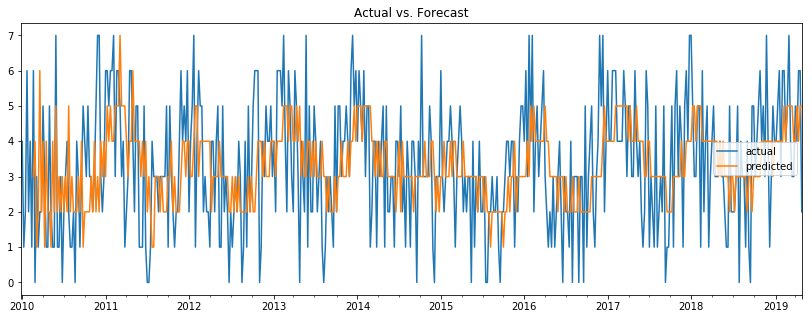

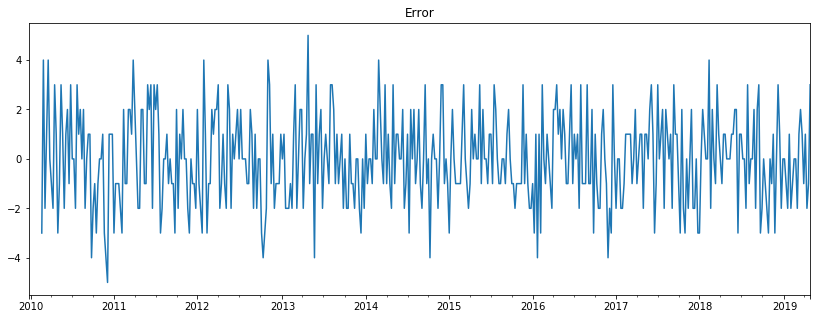

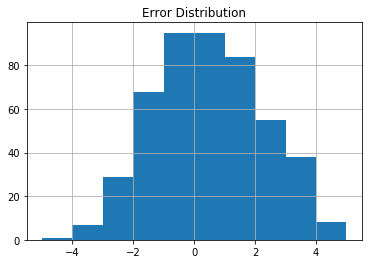

Error stats:
count    480.000000
mean      -0.020833
std        1.797581
min       -5.000000
25%       -1.000000
50%        0.000000
75%        1.000000
max        5.000000
Name: holt_winters, dtype: float64


In [6]:
es_result = evalute_model('holt_winters', predict_es, X, seasonal_periods=8, horizon=1, seasonal='add')
display_results(es_result)

In [7]:
# Sanity check
es = ExponentialSmoothing(X.head(8).astype(float), seasonal_periods=8, seasonal='add')
es_fit = es.fit()
es_fit.forecast(3)

/anaconda3/envs/py37-ds/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)


2010-02-22    3.0
2010-03-01    4.0
2010-03-08    1.0
Freq: W-MON, dtype: float64

In [8]:
es_result.results.loc['2010-02-22':'2010-03-08', 'predicted']

2010-02-22    3.0
2010-03-01    4.0
2010-03-08    1.0
Name: predicted, dtype: float64